In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


In [2]:
def extract_hog_features_recursive(input_dir, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    features = []
    filenames = []
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp')
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            if filename.lower().endswith(supported_formats):
                img_path = os.path.join(root, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                hog_feature = hog(img, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True)
                features.append(hog_feature)
                rel_path = os.path.relpath(img_path, input_dir)
                filenames.append(rel_path)
    return np.array(features), filenames


In [3]:
image_csv = pd.read_csv('dataset_stats.csv')
image_csv.head()

,class,image_count,avg_width,avg_height,min_width,min_height,max_width,max_height,formats,corrupt_files
0,adidas_forum_high,150,143,124,78,81,162,140,jpeg,0
1,adidas_ultraboost,150,142,128,93,49,162,140,jpeg,0
2,new_balance_550,150,134,129,79,40,162,140,jpeg,0
3,new_balance_574,150,131,133,78,68,162,140,jpeg,0
4,converse_one_star,150,138,130,82,67,162,140,jpeg,0


In [4]:
# check images format
image_csv['formats'].unique()

array(['jpeg', 'jpeg, png'], dtype=object)

In [5]:
input_dir = r'grayscale_images'

x, filenames = extract_hog_features_recursive(input_dir)

# 生成标签
y = [f.split(os.sep)[0] for f in filenames]
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)  #, test_size=0.2

In [12]:
rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.2397582269979852
                                     precision    recall  f1-score   support

                  adidas_forum_high       0.22      0.42      0.29        38
                   adidas_forum_low       0.50      0.17      0.26        23
                     adidas_gazelle       0.33      0.35      0.34        37
                      adidas_nmd_r1       0.39      0.29      0.33        24
                       adidas_samba       0.00      0.00      0.00        18
                  adidas_stan_smith       0.23      0.24      0.23        37
                   adidas_superstar       0.11      0.04      0.06        23
                  adidas_ultraboost       0.26      0.38      0.31        37
                 asics_gel-lyte_iii       0.53      0.39      0.45        23
             converse_chuck_70_high       0.40      0.21      0.28        19
              converse_chuck_70_low       0.20      0.30      0.24        37
converse_chuck_taylor_all-star_high       0.33

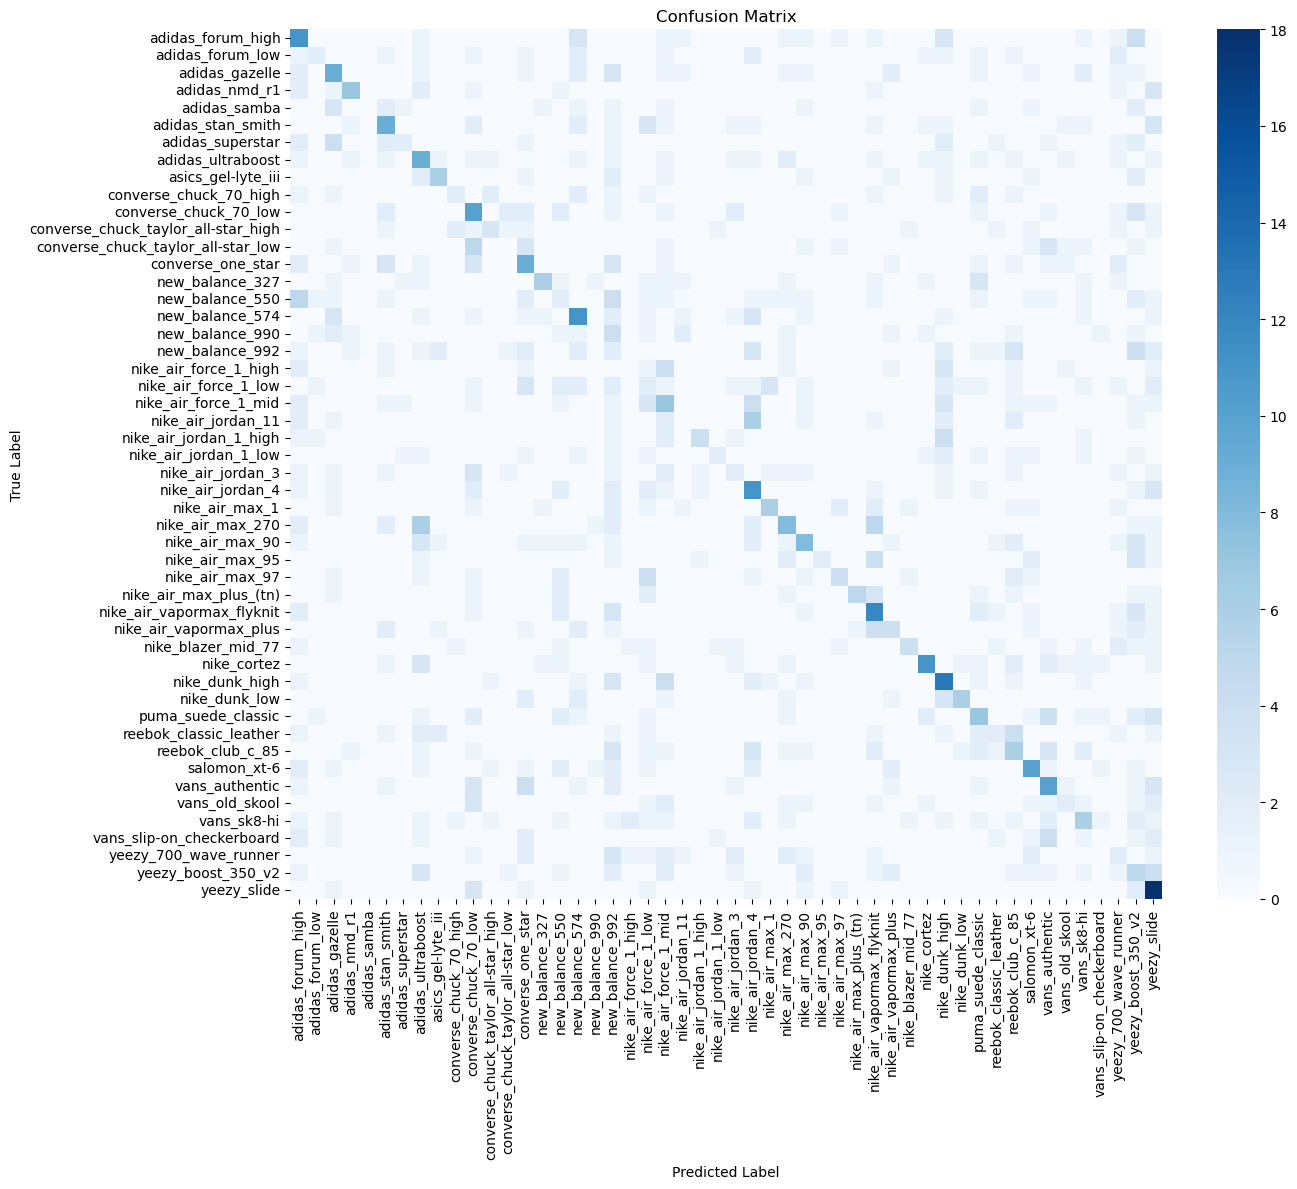

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

uniques = le.classes_

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, 
            xticklabels=uniques, 
            yticklabels=uniques, 
            cmap='Blues', 
            fmt='d')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
